# Test Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [2]:
amazon = pd.read_csv('/Users/Aaron_hill/Dropbox/data/ml_19/amazon_data/raw_data_test.csv')
print(amazon.shape)

(91000, 14)


In [3]:
print(amazon.loc[0, "Text"])

I really hate to give this coffee a bad review, especially after seeing all of the positive reviews, but it was pretty terrible.  I hate that I got three bags of it and will take it into the office where we drink any generic coffee that's on sale.  I make my coffee in a french press to preserve the oils.  There are no oils in this coffee.  It's basically colored water.


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      189701        133920  133921  B001E5DZUC  A1XVCNMSV13FJD   
1      311476        382519  382520  B003GADBDO  A3T0OTH5072YRE   
2      150296        388694  388695  B000Z91RGC  A1GF8FZHHU3Y1Q   
3      404130        492372  492373  B0000GHNWM  A1TJT6GXDGNN8Q   
4      218471        242244  242245  B004W3CXC4  A1H71B8U4HAJ1Y   

                   ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                        Kyong                     1                       1   
1  M. Reynard "kairosdreaming"                     0                       0   
2                        ocdme                     0                       0   
3                   Opinunated                     0                       0   
4            Jemi E. Broussard                     1                       2   

   Score        Time                                            Summary  \
0      2  1280707200                     

### Feature extraction on natural language data

In [5]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [6]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 131072)


In [7]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [8]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [9]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      2        371
1      4       1270
2      5        250
3      4       1773
4      5        436
5      2       1181
6      5        309
7      5        177
8      1        186
9      5        123
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [10]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 131074)


### Create `X`, scaled matrix of features

In [11]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 131074)


### create `y`, vector of Labels

In [12]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [13]:
# MODEL: ordinary least squares
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X, y)
# joblib.dump(ols, 'ols.pkl') # pickle
ols = joblib.load('ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

{'Pos': 6663, 'Neg': 84337, 'TP': 3506, 'TN': 39766, 'FP': 44571, 'FN': 3157, 'Accuracy': 0.4755164835164835, 'Precision': 0.07292468332050668, 'Recall': 0.5261894041722948, 'desc': 'ols'}


In [14]:
# MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle
svm = joblib.load('svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 6663, 'Neg': 84337, 'TP': 1660, 'TN': 78692, 'FP': 5645, 'FN': 5003, 'Accuracy': 0.882989010989011, 'Precision': 0.2272416153319644, 'Recall': 0.24913702536395016, 'desc': 'svm'}


In [15]:
# MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
lgs = joblib.load('lgs.pkl')

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6663, 'Neg': 84337, 'TP': 1689, 'TN': 79210, 'FP': 5127, 'FN': 4974, 'Accuracy': 0.889, 'Precision': 0.24779929577464788, 'Recall': 0.2534894191805493, 'desc': 'lgs'}


In [16]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 6663, 'Neg': 84337, 'TP': 2578, 'TN': 71626, 'FP': 12711, 'FN': 4085, 'Accuracy': 0.8154285714285714, 'Precision': 0.16861796062528614, 'Recall': 0.3869128020411226, 'desc': 'nbs'}


In [17]:
# MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
prc = joblib.load('prc.pkl')

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Pos': 6663, 'Neg': 84337, 'TP': 1684, 'TN': 78706, 'FP': 5631, 'FN': 4979, 'Accuracy': 0.8834065934065934, 'Precision': 0.23021189336978812, 'Recall': 0.25273900645354946, 'desc': 'prc'}


In [18]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 6663, 'Neg': 84337, 'TP': 968, 'TN': 82901, 'FP': 1436, 'FN': 5695, 'Accuracy': 0.9216373626373626, 'Precision': 0.40266222961730447, 'Recall': 0.14527990394717094, 'desc': 'rdg'}


In [19]:
# MODEL: Decision Tree Classifier
# from sklearn import tree
# dtc = tree.DecisionTreeClassifier(max_depth=100)
# dtc.fit(X_matrix, y)
# joblib.dump(dtc, 'dtc.pkl') # pickle
dtc = joblib.load('dtc.pkl')

dtc_performance = BinaryClassificationPerformance(dtc.predict(X_matrix), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 6663, 'Neg': 84337, 'TP': 1416, 'TN': 83286, 'FP': 1051, 'FN': 5247, 'Accuracy': 0.9307912087912088, 'Precision': 0.573976489663559, 'Recall': 0.2125168842863575, 'desc': 'dtc'}


### ROC plot to compare performance of various models and fits

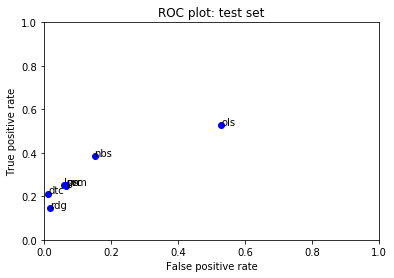

In [20]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance, ols_performance, dtc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [21]:
amazon.loc[0, "Text"]

"I really hate to give this coffee a bad review, especially after seeing all of the positive reviews, but it was pretty terrible.  I hate that I got three bags of it and will take it into the office where we drink any generic coffee that's on sale.  I make my coffee in a french press to preserve the oils.  There are no oils in this coffee.  It's basically colored water."

In [22]:
amazon.loc[0, "helpful"]

False

In [23]:
ridge_predictions = rdg.predict(X)

In [24]:
ridge_predictions.shape

(91000,)

In [25]:
print(ridge_predictions)

[False False False ... False False False]


In [26]:
# false positives

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (amazon.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazon.loc[i, "Time"])))
                print(amazon.loc[i, "Score"])
                print(amazon.loc[i, "HelpfulnessDenominator"])
                print(amazon.loc[i, "ProductId"])
                print(amazon.loc[i, "Text"])
                print('* * * * * * * * * ')

2603
2012-05-14 00:00:00
5
0
B004QJEJ1M
My only complaint is how long it took to ship from the UK to the United States. But, that's not Marmite's fault. I am a recent devotee of Marmite, having only found out about it, and that I could get it here a couple months ago. After devouring 2 bottles of the regular, I had to order this. Man, am I glad I did. I mean Marmite is good, but if I am going to pay a premium for it anyway (125g jar here for $6), then $15 for a jar twice the size, with twice the taste is worth it to me. Thanks for making this available to me.
* * * * * * * * * 
3011
2011-11-27 00:00:00
5
2
B000EDK6FM
Bob's Red Mill four pack of gluten free organic quinoa flour is very good tasting and high quality. I've used it in pancakes, muffins, and making cereals. It blends well with oat, teff, brown rice, and sorghum flours. I also appreciate that this flour has 4 grams of protein per 1/4 cup.
* * * * * * * * * 
3501
2011-01-21 00:00:00
5
0
B001E5DY4O
I love this blend of Caffe A